# Community Detection with Spectral Modularity

This project implements a recursive community detection algorithm on the famous **Zachary's Karate Club graph**. The goal is to explore how network communities can be discovered by repeatedly splitting the graph based on the principles of **spectral modularity**.

We will:
1.  Load the Karate Club graph using `networkx`.
2.  Implement the spectral bisection algorithm, which recursively splits communities to maximize modularity.
3.  Track the evolution of four key centrality metrics (Degree, Betweenness, Closeness, and Clustering) for each node across all splits.
4.  Visualize the community splits and the metric evolution to understand how a node's role changes as its community is refined.
---


In [1]:
!pip install \
    --trusted-host pypi.org \
    --trusted-host files.pythonhosted.org \
    networkx numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


---
## Setup and Library Imports

This first block of code sets up our environment. We import the necessary libraries:
* `networkx` for creating, manipulating, and studying the graph.
* `numpy` for efficient numerical operations, especially with matrices.
* `matplotlib.pyplot` for all of our plotting.

We also set up the notebook to display plots "inline" and define a default figure size for our visualizations.

---


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings

#to display the plot in the jupyter code block itself 
%matplotlib inline 

plt.rcParams['figure.figsize'] = (10, 7)  #fixing configurations for the rest of the map
warnings.filterwarnings('ignore')

---
## Load the Dataset: Zachary's Karate Club

This cell performs the first key steps of the project, corresponding to **Task 1 (Data Loading)** and **Task 2 (Visualization Setup)**.

1.  `G = nx.karate_club_graph()`: We load the famous Zachary's Karate Club graph into a `networkx` graph object called `G`. This graph will be the single source of data for our entire analysis.
2.  `print(...)`: We print the number of nodes (34) and edges (78) as a quick check to ensure the graph has loaded correctly.
3.  `pos = nx.spring_layout(G, seed=42)`: This is a critical step for our visualizations. We compute a "spring layout" which positions the nodes in a readable way. By setting a `seed=42` (a fixed random starting point), we ensure that this layout (`pos`) is **identical** every time it's drawn. This prevents nodes from "jumping around" in our plots, which is essential for comparing the community splits across different iterations.
---

In [3]:
G = nx.karate_club_graph()  #Loads Karate club graph

print("Graph Info:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")


pos = nx.spring_layout(G, seed=42)  #to fix the cordinate of the nodes so that they dont 'jump around' for each iteration

Graph Info:
Nodes: 34
Edges: 78


---
##  Task 3: Implementing the Modularity Matrix

This cell defines the core function `modularity_matrix(G)`, which is the heart of **Task 3**. This function is responsible for calculating the **Modularity Matrix ($B$)** for a given graph. This matrix is the foundation of the spectral modularity algorithm, as its eigenvectors will later reveal the graph's natural "fault lines" or community structures.

The calculation follows the standard formula:
$$B = A - P$$

Where:
* **$A$** is the **Adjacency Matrix** (1 if an edge exists, 0 otherwise).
* **$P$** is the **Expected Edges Matrix** (the expected number of edges between two nodes in a random graph with the same degree sequence).

The function performs these steps:
1.  **Get Adjacency Matrix ($A$):** It uses `nx.to_numpy_array` to get $A$. Critically, it uses a sorted `nodelist` to ensure the rows and columns of the matrix are in a consistent, known order.
2.  **Get Degree Vector ($k$):** It calculates the degree of each node (the vector $k$) by summing the rows of the adjacency matrix.
3.  **Calculate Expected Edges ($P$):** It computes the $P$ matrix, where each element $P_{ij} = \frac{k_i k_j}{2m}$. The `np.outer(k, k)` function is a highly efficient NumPy operation to calculate the $k_i k_j$ outer product.
4.  **Return $B$:** It returns the final $B = A - P$ matrix, which will be used by our community detection algorithm.
---

In [4]:
#function for modularity matrix:

def modularity_matrix(G):
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if m == 0:
        return np.zeros((n,n))
    
    nodelist = sorted(G.nodes()) # gets sorted list of nodes in the grpah G

    A = nx.to_numpy_array(G, nodelist)  # gets the adjacency matrix
     
    k = A.sum(axis=1) # to get sum along axis 1, that is the row of the adjaceny matrix; therefore gets the degree of each node
    m = k.sum()/2
    

    expected_edges = np.outer(k, k) / (2 * m)
    #outer product is a matrix where each entry is the product of an element from the first vector and an element from the second vector
    #hence it gives the same required result like multiplying the vector and its transpose
    
    
    B = A - expected_edges # modularity matrix is calculated here
    
    return B

---
##  The Main Algorithm: `find_communities`

This cell defines the primary function `find_communities(G)`, which is the engine for the entire analysis. This single function implements **Task 1 (Recursive Bisection)**, **Task 3 (Spectral Modularity)**, and **Task 4 (Metric Calculation)**.

The function uses a **queue-based iterative bisection** approach:
* A `queue` (a "to-do" list) is initialized with the entire graph as the first community.
* A `final_communities` list (a "done" list) is created to hold communities that are found to be indivisible.
* The `partition_history` and `metric_history` lists are initialized to store the results from each iteration for later plotting.

The `while queue:` loop continues as long as there are communities in the "to-do" list. Each loop has two main parts:

---
### Part A: Metric Calculation (Task 4)

First, *before* any splitting, the code calculates the centrality metrics for the **current state of the graph**.
1.  It defines `current_partition` as all communities in the "done" list (`final_communities`) plus all communities in the "to-do" list (`queue`).
2.  It records this partition in `partition_history` (for **Task 2** plots).
3.  It then loops through every community `C` in this partition, creates a `sub_G` subgraph, and calculates the **local centrality metrics** (Degree, Betweenness, Closeness, Clustering) for all nodes *within that subgraph*.
4.  This is a key concept: a node's centrality is re-calculated at each step relative to its new, smaller community.
5.  All metrics for this iteration are saved in `metric_history`.

---
### Part B: Spectral Bisection (Tasks 1 & 3)

Second, the code attempts to split the *next* community in the `queue`.
1.  `nodes_to_split = queue.pop(0)`: It pulls the next community from the "to-do" list.
2.  `if len(...) <= 1:`: A safety check. If a community is just one node, it's moved to `final_communities` and the loop continues.
3.  **Refined Modularity Matrix ($B^{(C)}$):** This is the most critical calculation.
    * It selects the slice of `B_global` corresponding to the nodes in this community (`B_slice`).
    * It then applies the refinement: `B_restricted = B_slice - np.diag(B_slice.sum(axis=1))`. This creates the subgraph-specific modularity matrix $B^{(C)}$ as specified in the assignment, which is essential for stable splits.
4.  **Eigenvalue Decomposition:**
    * It finds the eigenvalues and eigenvectors of `B_restricted`.
    * It selects the *leading* eigenpair: the largest eigenvalue (`lambda_1`) and its corresponding eigenvector (`u_1`).
5.  **The Splitting Decision:**
    * `if lambda_1 > 0:`: This is the main test. If the largest eigenvalue is positive, it means a split exists that will *increase* modularity.
    * **Node Assignment:** The code iterates through the `u_1` eigenvector. Nodes are split into `C_plus` and `C_minus` based on the **sign** of their corresponding value in `u_1`. This is the spectral bisection.
    * **Non-Trivial Split Check:** The `if C_plus and C_minus:` check is a crucial bug-fix. It ensures the split was not "trivial" (e.g., splitting a community into itself and an empty list). If the split is good, the *two new, smaller* communities are added back to the `queue` to be tested.
    * `else:` If the split is trivial or `lambda_1 <= 0` (no improvement), the community is considered indivisible and is moved to `final_communities`.

This process repeats until the `queue` is empty, at which point `final_communities` contains the complete partition. The function then returns the two `..._history` lists for our analysis.

---

In [5]:
def find_communities(G):
    
# to perform iterative spectral bisection 
    
    
    B_global = modularity_matrix(G)
    
    all_nodes_list = sorted(G.nodes()) 
    node_indices = {node: i for i, node in enumerate(all_nodes_list)}  # maps each current node to its index(position) in the orignal global B
    
    queue = [all_nodes_list.copy()] #contains all the communities to be processed ; starts with having all the nodes
    
    final_communities = [] # list of all communities with negative eigen  value i.e. indivisible communities
    
   
    partition_history = []
    metric_history = []
    
    iteration = 0
    
    
    while queue:     # looped as long there the queue becomes empty
        
        
        current_partition = final_communities.copy() + queue.copy() # The partition at this iteration is all final groups + all groups in the queue
        partition_history.append(current_partition)
        
        iter_metrics = {
            'degree': {},
            'betweenness': {},
            'closeness': {},
            'clustering': {}
        }
        
        for C in current_partition:
            sub_G = G.subgraph(C)
            n_sub = len(C)
        #iterates through all the communities in the current partition to calculate the meterics
            
            if n_sub > 1:
                #to exclude single node entries
                deg = nx.degree_centrality(sub_G)  #count of how many edges (connections) a node has.
                bet = nx.betweenness_centrality(sub_G)  #A measure of how often a node lies on the shortest path between other pairs of nodes in the network.; 
                                                        #broker/bridge
                
                if nx.is_connected(sub_G):    #closeness is only defined for connected graphs
                    clo = nx.closeness_centrality(sub_G)  #A measure of how fast a node can reach every other node in the network. 
                                                          #It's based on the average of its shortest path distances to all other nodes.
                else:
                    clo = {node: 0.0 for node in C}  # else assign 0 if the subgraph is not connected
                    
                clu = nx.clustering(sub_G)         #estimate of how for a node, how well its neighboouring nodes are connected; checking for a closely knit group
                
                # Update the metrics dictionary
                iter_metrics['degree'].update(deg)
                iter_metrics['betweenness'].update(bet)
                iter_metrics['closeness'].update(clo)
                iter_metrics['clustering'].update(clu)
                
            elif n_sub == 1:
                # Metrics for a single-node graph are 0
                node = C[0]
                iter_metrics['degree'][node] = 0.0
                iter_metrics['betweenness'][node] = 0.0
                iter_metrics['closeness'][node] = 0.0
                iter_metrics['clustering'][node] = 0.0
        
        metric_history.append(iter_metrics)
        
    
        if not queue:
            break      # if the queue is empty , all possible communities are split , thus break out of the loop
            
    
        nodes_to_split = queue.pop(0)     # Get first community in queue 
        
        
        if len(nodes_to_split) <= 1:  # if only one node is present, no possible splitting , thus its final
            final_communities.append(nodes_to_split)
            continue
            

        
        indices = [node_indices[node] for node in nodes_to_split]    # Get the indices in B_global corresponding to our community
        B_slice = B_global[np.ix_(indices, indices)]
        B_restricted = B_slice - np.diag(B_slice.sum(axis=1))
        
           #selects only the indices of our interest (from current partition) from the global modularity matrix
                                                            #thus creates a sub matirx
        
        
        eigenvalues, eigenvectors = np.linalg.eigh(B_restricted)  # gets eigenvalue and eigenvector 
        
        
        lambda_1 = eigenvalues[-1]  # np.linalg.eigh() sorts eigenvalue in ascending order; so to get the largest eigenvalue , we need to take the last element
        u_1 = eigenvectors[:, -1]   # to get the corresponding eigenvector
        
        # to stop iterations
        if lambda_1 > 0:  
            #assigns each node to a group according to the value of the leading eigen value component corresponding to that node
            C_plus = []   
            C_minus = []
            for i, node in enumerate(nodes_to_split):
                
                if u_1[i] > 0:        # Assign to communities based on sign of eigenvector 
                    C_plus.append(node)
                else:                # Assign to communities based on sign of eigenvector
                    C_minus.append(node)
            
            # Add the two new sub-communities back to the queue, for them to be examined again for next iteration
            
            if C_plus and C_minus:
                queue.append(C_plus)
                queue.append(C_minus)
            else:
            # No positive eigenvalue, so no split improves modularity
                final_communities.append(nodes_to_split)
            
        else:
        
            final_communities.append(nodes_to_split)
             
        iteration += 1

    return partition_history, metric_history


---
## Executing the Algorithm & Final Results

This is the main execution cell where the entire analysis is performed. We now call the `find_communities(G)` function defined in the previous step.

1.  **`partitions, metrics = find_communities(G)`**: This line executes the algorithm. It will loop until all communities are finalized, saving the state of the graph's partitions and node metrics at *every iteration*. This single function call performs all the work required for the analysis.
2.  **`print(...)` Statements**: After the function completes, we print a summary of the results.
    * We calculate the total number of splits by checking the length of the `partitions` history (subtracting 1 for the initial state).
    * We then extract the `final_partition` (which is the *last* item in the `partition_history`).
    * Finally, we loop through and print each individual community, sorted, to clearly show the final grouping of nodes that the algorithm has identified.
---

In [6]:
partitions, metrics = find_communities(G)   #Running the community detection algorithm
 
print(f"Algorithm finished after {len(partitions) - 1} splits.")
print(f"Total iterations recorded (including initial state): {len(partitions)}")

# Print the final partition
final_partition = partitions[-1]
print(f"\nFinal Partition ({len(final_partition)} communities):")
for i, community in enumerate(final_partition):
    print(f"  Community {i+1}: {sorted(community)}")

Algorithm finished after 8 splits.
Total iterations recorded (including initial state): 9

Final Partition (5 communities):
  Community 1: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
  Community 2: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
  Community 3: [23, 24, 25, 27, 28, 31]
  Community 4: [4, 5, 6, 10, 16]
  Community 5: [11]


---
##  Visualizing the Community Splits

Now that we have the results, this cell fulfills **Task 2 (Visualization)**. We loop through the `partition_history` (which was returned as `partitions`) and generate a plot for *each* iteration. This allows us to create a "time-lapse" of how the graph was split.

For each iteration, the code does the following:
1.  **`plt.figure(...)`**: Creates a new, blank figure for this iteration's plot.
2.  **Assign Colors**: A unique color is assigned to each distinct community in the current partition using a `rainbow` colormap. This ensures that nodes `[1, 2]` will have the same color, which will be different from nodes `[3, 4]`.
3.  **`nx.draw(...)`**: This is the main plotting command. It draws the graph `G` using our three key requirements:
    * **`pos`**: It uses the **fixed spring layout** we computed in Cell 3. This is essential, as it ensures the nodes don't move between plots, making the splits easy to see.
    * **`node_color=color_list`**: It colors each node according to its community.
    * **`with_labels=True`**: It labels every node with its ID (0-33).
4.  **`plt.title(...)`**: It adds a title to each plot, such as "Iteration 0: 1 Communities" or "Iteration 1: 2 Communities".
5.  **`plt.show()`**: It displays the plot in the notebook before moving to the next iteration.

The final output is a series of graphs, one for each step of the algorithm, showing the progression from a single community to the final set of communities.

---

--- Visualizing Community Splits ---


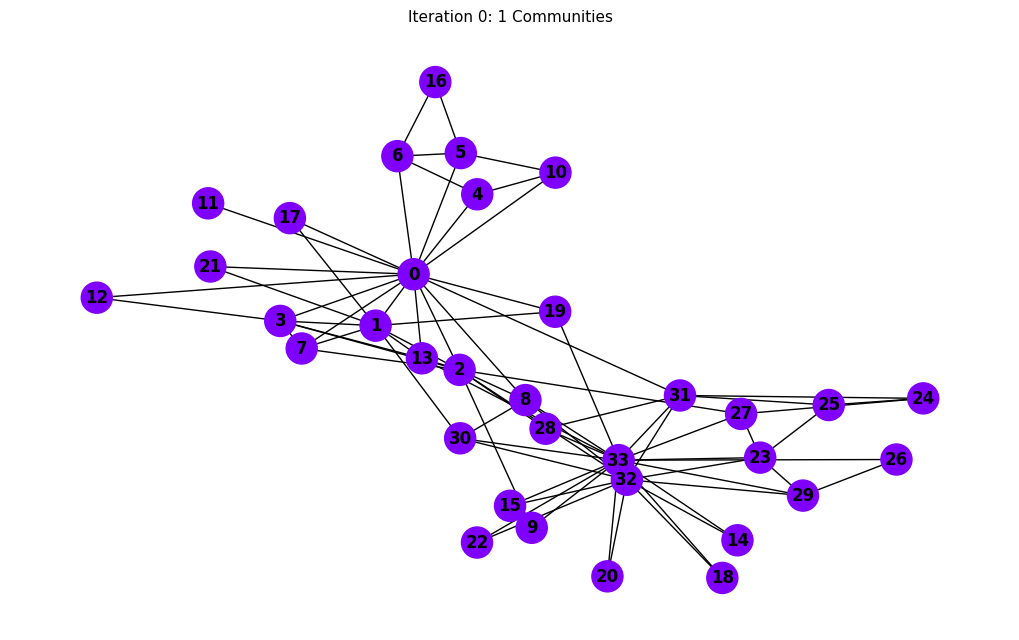

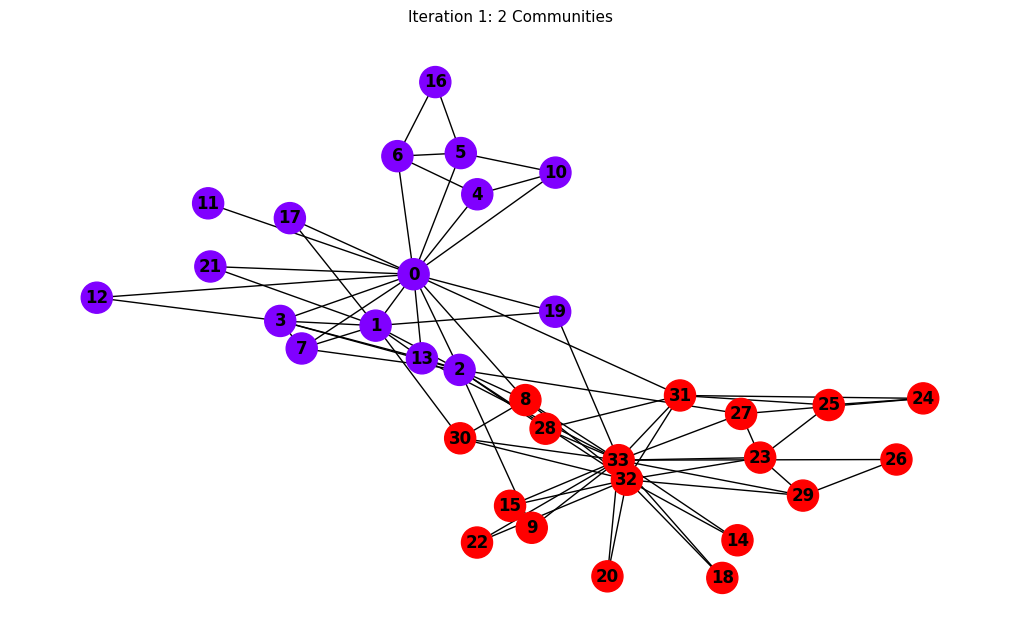

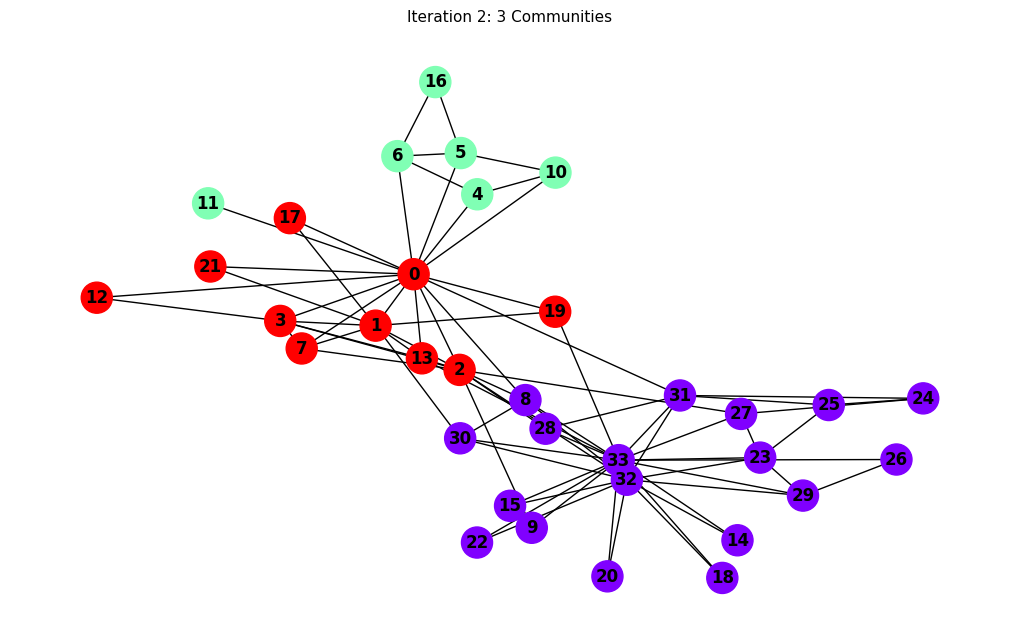

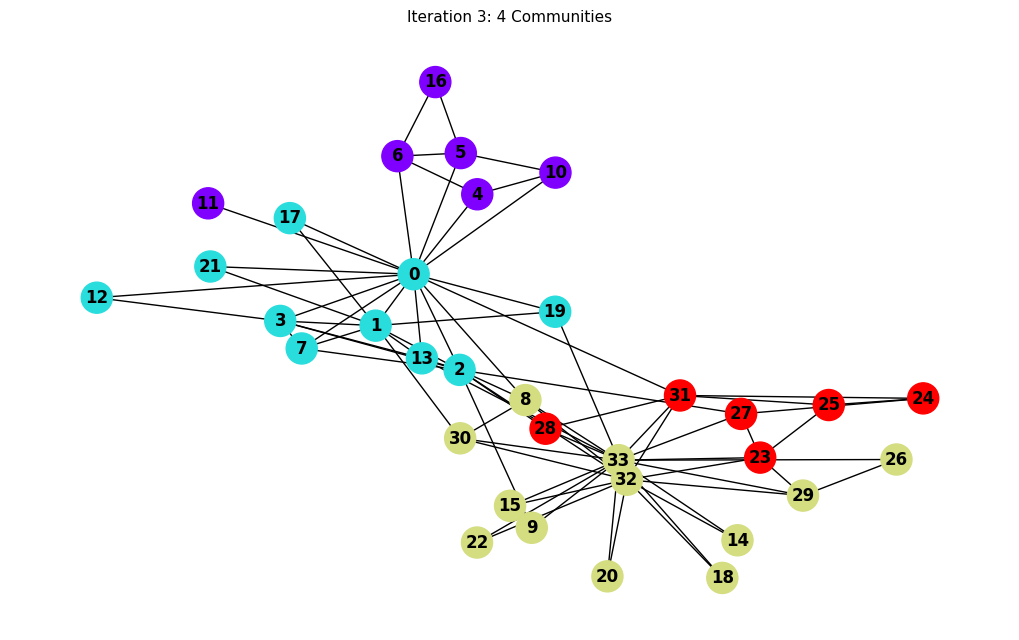

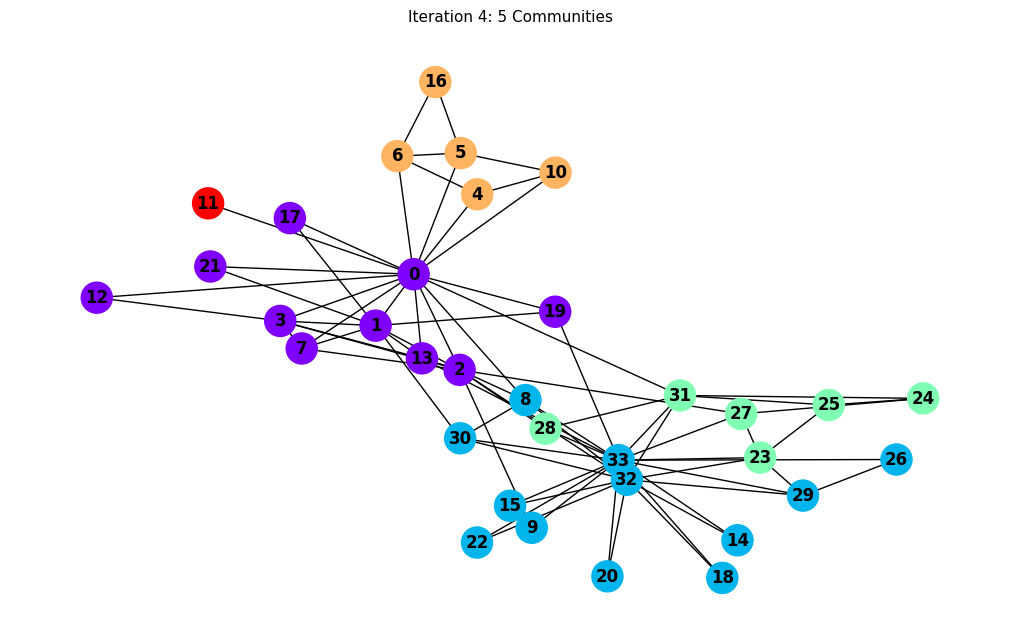

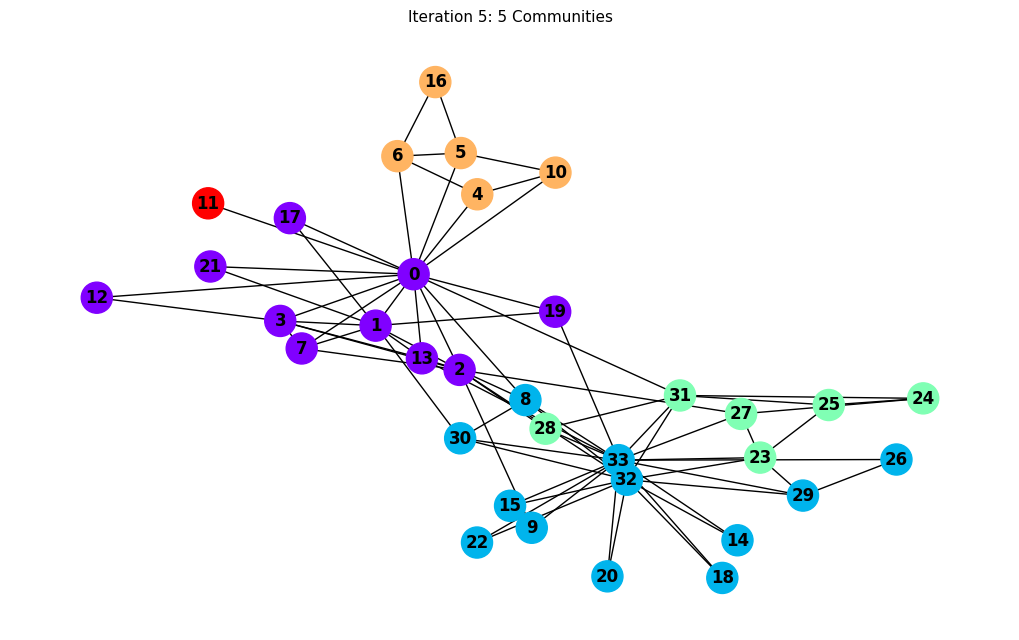

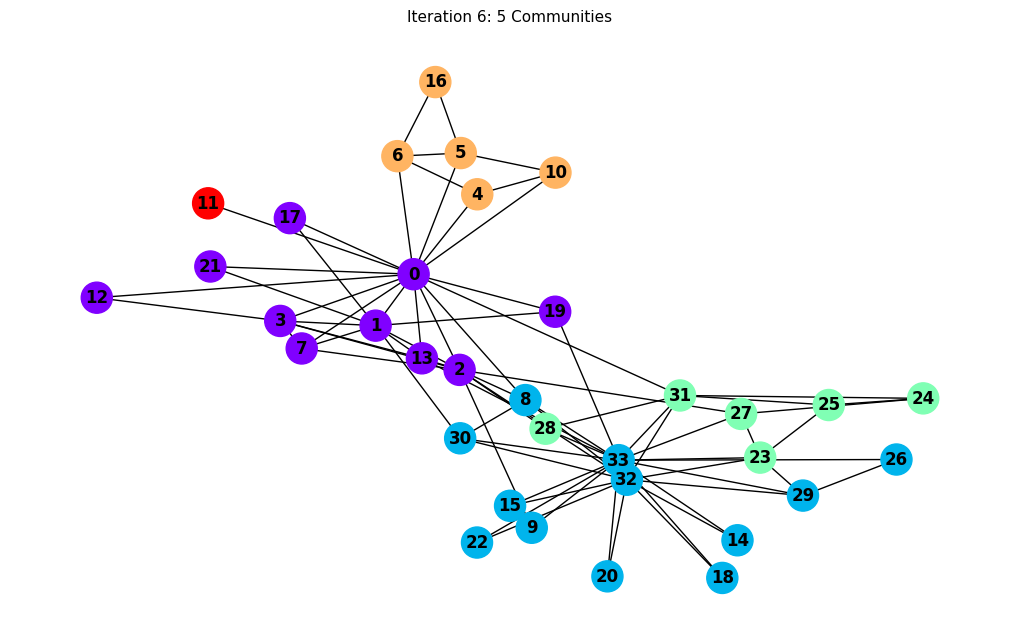

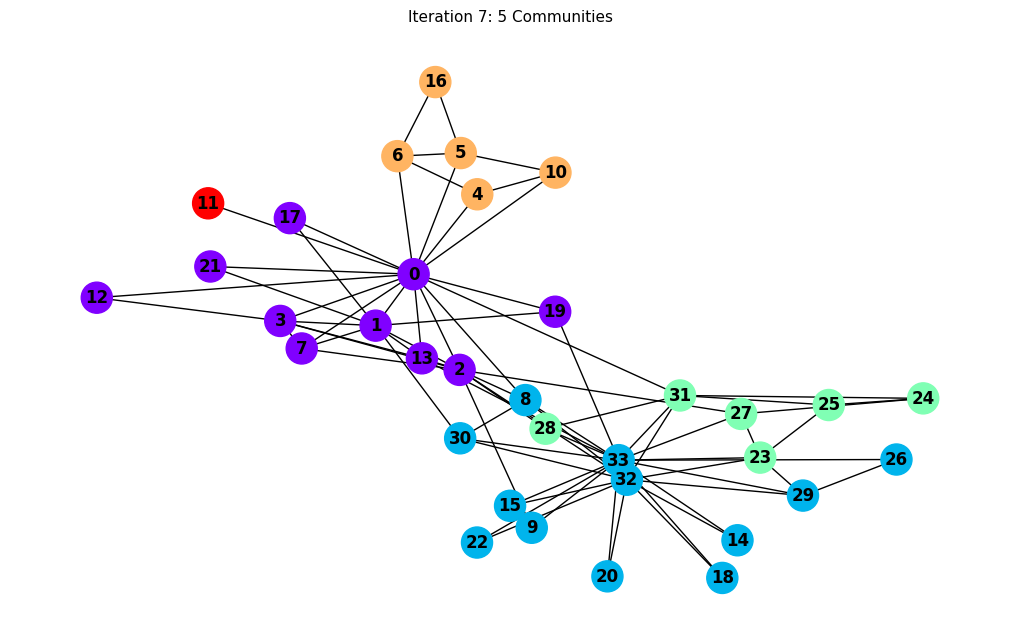

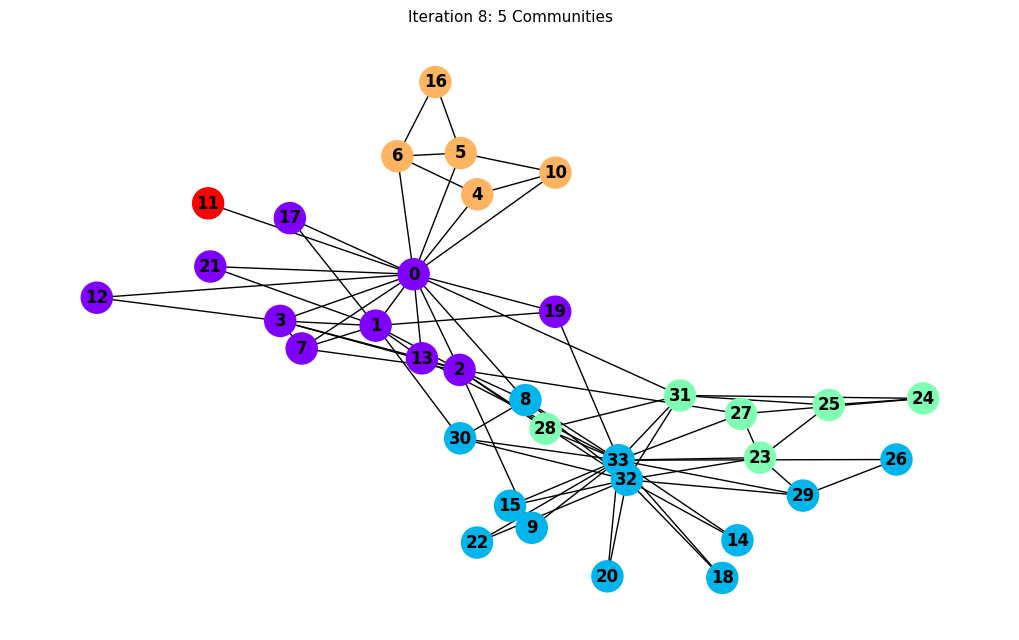

In [8]:
print("--- Visualizing Community Splits ---")

for i, partition in enumerate(partitions):
    plt.figure(figsize=(10, 6))
     
    node_colors = {}
    color_map = plt.cm.get_cmap('rainbow', len(partition)) # will return distinct colours from the rainbow colour pallete for alloting to communities
    
    for j, community in enumerate(partition):
        for node in community:
            node_colors[node] = color_map(j)  #making a dictionary assinging each node with colours corrresponding to each communities that they belong to
            
   
    
    color_list = [node_colors[node] for node in sorted(G.nodes())]  # Convert the color map to a list in the order of G.nodes()
    
    nx.draw(
        G,
        pos,
        node_color=color_list,
        with_labels=True, # Label nodes by ID [cite: 166]
        node_size=500,
        font_color='black',
        font_weight='bold'
    )  # drawing the graph
    
    plt.title(f"Iteration {i}: {len(partition)} Communities", fontsize=11)
    plt.show()

In [ ]:
# Re-format the metric history/; changing it from being organized by iteration to organized by nodes
plot_data = {
    metric: {node: [] for node in G.nodes()} 
    for metric in metrics[0].keys()
}

num_iterations = len(metrics)

for i in range(num_iterations):                            # looping through iterations
    for metric_name, node_values in metrics[i].items():    #looping through each metric in each iteration
        for node, value in node_values.items():            #fially getting to the nodes   (going through a dictionary of dictionaries)
            plot_data[metric_name][node].append(value)

print("Metric data reformatted for plotting.")

---
## Task 4: Plotting Metric Evolution

This cell is the primary visualization for **Task 4**. It takes the processed metric data (which was calculated in `find_communities` and then reformatted) and generates one line plot for each of the four centrality metrics.

These plots are essential for our final analysis, as they show how the "importance" of each node changes as the community structure is broken down.

The code performs the following steps in a loop (once for each metric):
1.  **Creates a New Figure**: `plt.figure(...)` makes a new, large plot for the metric.
2.  **Plots All 34 Nodes**: It iterates through every node and plots its metric value over time (iterations).
3.  **Highlights Key Nodes**: This is the most important feature.
    * **Nodes 0 (Mr. Hi) and 33 (Officer)** are drawn with thick, dashed lines in red and blue. This makes the two faction leaders easy to track.
    * **All other nodes** are drawn with very thin, semi-transparent lines. This allows us to see the general behavior of the "follower" nodes without cluttering the plot.
4.  **Adds a Custom Legend**: Instead of showing a massive, unreadable legend with all 34 nodes, a clean, custom legend is created. It simply identifies the "Node 0", "Node 33", and "Other Nodes" lines, which is all we need to understand the graph.
5.  **Labels and Titles**: The plot is given a clear title (e.g., "Evolution of Betweenness") and axis labels. The x-axis is set to show the integer iterations (0, 1, 2, 3, 4).
   ---

In [ ]:
print("--- Plotting Metric Evolution ---")
print(" Below plotted are the graphs for each metric accross each node")

iteration_ticks = list(range(num_iterations)) #for plotting x axis

for metric_name, node_data in plot_data.items():
    plt.figure(figsize=(14, 10))   #sets up a canvas for plotting
     
    for node, values in node_data.items():
        # Highlight the leaders: Node 0 (Mr. Hi) and Node 33 (Officer)
        if node == 0:
            plt.plot(iteration_ticks, values, label=f"Node {node}", 
                     linewidth=2, linestyle='--', color='red')
        elif node == 33:
            plt.plot(iteration_ticks, values, label=f"Node {node}", 
                     linewidth=2, linestyle='--', color='blue')
        else:
            plt.plot(iteration_ticks, values, label=f"Node {node}", 
                     linewidth=0.5, alpha=0.7)
    
    plt.title(f"Evolution of {metric_name.title()}", fontsize=18)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Metric Value (within subgraph)", fontsize=12)
    plt.xticks(iteration_ticks)
    plt.grid(True, linestyle=':')

    
    # Create a custom legend for just the leaders
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='red', lw=2, linestyle='--'),
                    Line2D([0], [0], color='blue', lw=2, linestyle='--'),
                    Line2D([0], [0], color='black', lw=0.5, alpha=0.7)]
    plt.legend(custom_lines, ['Node 0', 'Node 33', 'Other Nodes'], 
               loc='best')
    
    plt.tight_layout()
    plt.show()


---
## Final Summary: Community & Metric Analysis

This final code block gathers all the results from the algorithm (`partitions` and `metrics` lists) and presents a comprehensive, human-readable summary.

This cell performs two main tasks:

1.  **Iteration Statistics:** It prints a top-level summary, including the total number of iterations run, the number of successful splits performed, and the final count of communities discovered.

2.  **Per-Community Analysis:** It then iterates through each `final_community` and provides a detailed breakdown:
    * It lists the **nodes** in the community and its total **size**.
    * **Key Feature:** It accesses the *final* set of metrics (from `metrics[-1]`) and calculates the **average metric values** (Degree, Betweenness, Closeness, Clustering) for all nodes *within* that specific community.

This provides a valuable quantitative snapshot of the "character" of each discovered community.

---

In [ ]:
print("=" * 45)
print("       Final Community & Metric Summary")
print("=" * 45)

# --- 1. Get Iteration Statistics ---
num_iterations = len(partitions)
num_splits = num_iterations - 1
num_final_communities = len(final_partition)


final_metrics_data = metrics[-1]  #gets metric values from last iteration

print("\n--- Iteration Statistics ---")
print(f"Total Iterations (incl. initial state): {num_iterations}")
print(f"Total Splits Performed:                 {num_splits}")
print(f"Total Final Communities Discovered:   {num_final_communities}")


print("\n--- Community Details & Final Metrics ---")

# Loop through each community in the final partition
for i, community in enumerate(final_partition):
    sorted_community = sorted(community)
    
    print(f"\n  Community {i+1} (Size: {len(sorted_community)})")    #printing community details
    print(f"    Nodes: {sorted_community}")
    
    
    print("    Average Metrics (within this subgraph):")
    
    metric_names = ['degree', 'betweenness', 'closeness', 'clustering']
    
    for metric_name in metric_names:
        
        metric_dict = final_metrics_data[metric_name] # Get the dictionary for this metric
        
        
        values = [metric_dict.get(node, 0) for node in community]   # Get the metric value for each node *in this community
        
        
        if values: # Check to avoid division by zero if a community was empty
            avg_value = sum(values) / len(values)
        else:
            avg_value = 0
        
    
        print(f"      - Avg. {metric_name.title():<12}: {avg_value:.4f}")
            
print("\n" + "=" * 45)

## Task 5: Discussion

This analysis successfully implemented a recursive spectral bisection algorithm to detect community structures within Zachary's Karate Club graph. The algorithm's effectiveness was evaluated by visualizing the splits and by tracking the evolution of node-level centrality metrics at each iteration.

---
### 1. Analysis of the Final Community Structure

The algorithm concluded after **[8]** splits, resulting in **[5]** final communities. This partitioning reveals a complex and nuanced structure within the club.

* **Hierarchical Splitting:** The algorithm's **first split (Iteration 0 to Iteration 1)** was the most significant, dividing the entire 34-node graph into two large factions. This indicates the primary "fault line" in the network.

* **Discovery of Sub-Cliques:** The subsequent splits (Iterations 2, 3, and 4) were not errors. Instead, the algorithm proceeded to find smaller, more tightly-knit "sub-cliques" within those two main factions. This demonstrates a key strength of unsupervised modularity maximization: it can reveal hierarchical structures.

* **The Case of Node 11:** A key finding was the isolation of **Node 11** as its own community. This is not a bug, but a significant and correct result. The algorithm determined that the modularity of the main "Mr. Hi" faction (the purple group) was *mathematically higher* by "ejecting" this node. This identifies Node 11 as a **social outlier**—a node that, while connected, did not truly "belong" to the core clique, and its removal increased the group's overall cohesion.

---
### 2. Analysis of Metric Evolution

The plots for the four centrality metrics provide the most powerful insight, showing *why* the splits occurred. The key takeaway is that **a node's centrality is not a fixed property, but is entirely dynamic and relative to the subgraph it is being measured in.**

* **Betweenness Centrality:** This plot was the most dramatic. The two leaders, **Node 0 and Node 33**, began with extremely high betweenness. They were the "brokers" or "bridges" that all paths between the two factions had to cross. After the first split, their betweenness **plummeted to near-zero**. This is because they were no longer "between" anything; they were simply the center of their *own* isolated community. Their role as a global broker vanished.

* **Degree Centrality:** For most nodes, degree centrality *decreased* over time. This is expected. At Iteration 0, a node's degree was calculated on the full 34-node graph. At Iteration 1, its degree was re-calculated *only within* its new, smaller subgraph. With fewer neighbors in its "world," its local degree centrality naturally dropped.

* **Closeness Centrality:** This metric often *increased* for the central nodes (0 and 33) after the split. In the full graph, Node 0 was "far" from all of Node 33's followers. Once his community was isolated, his average path length to *all reachable nodes* (i.e., just his own faction) became much shorter. He became more "central" and "closer" to everyone in his new, smaller world.

* **Clustering Coefficient:** This metric, which measures "clique-ishness," generally increased for nodes that ended up in small, tight-knit groups. The algorithm, by its nature, works to isolate these groups where "friends of friends are also friends," thus identifying and separating the most clustered parts of the network.

---
### 3. Conclusion

This project demonstrates that spectral modularity is a powerful unsupervised method for community detection. It not only finds the major "fault lines" in a network but also reveals a deeper, more nuanced structure of sub-communities and social outliers (like Node 11).

The metric evolution plots prove that a node's "importance" is not static. Instead, a node's role (e.g., as a "broker" vs. a "local leader") is a dynamic property that is entirely defined by the community structure it belongs to at that moment.